# Data preparation

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"srikresna","key":"c90f9c19af6b129911ae9410dd23cde4"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d quachnam/inbreast-roi-mammography

 97% 657M/677M [00:12<00:00, 52.6MB/s]
100% 677M/677M [00:13<00:00, 54.5MB/s]


In [ ]:
!unzip inbreast-roi-mammography.zip

Archive:  inbreast-roi-mammography.zip
  inflating: description.csv         
  inflating: images/20586908_6c613a14b80a8591_MG_R_CC_ANON.png  
  inflating: images/20586934_6c613a14b80a8591_MG_L_CC_ANON.png  
  inflating: images/20586960_6c613a14b80a8591_MG_R_ML_ANON.png  
  inflating: images/20586986_6c613a14b80a8591_MG_L_ML_ANON.png  
  inflating: images/20587054_b6a4f750c6df4f90_MG_R_CC_ANON.png  
  inflating: images/20587080_b6a4f750c6df4f90_MG_R_ML_ANON.png  
  inflating: images/20587148_fd746d25eb40b3dc_MG_R_CC_ANON.png  
  inflating: images/20587174_fd746d25eb40b3dc_MG_L_CC_ANON.png  
  inflating: images/20587200_fd746d25eb40b3dc_MG_R_ML_ANON.png  
  inflating: images/20587226_fd746d25eb40b3dc_MG_L_ML_ANON.png  
  inflating: images/20587294_e634830794f5c1bd_MG_R_CC_ANON.png  
  inflating: images/20587320_e634830794f5c1bd_MG_L_CC_ANON.png  
  inflating: images/20587346_e634830794f5c1bd_MG_R_ML_ANON.png  
  inflating: images/20587372_e634830794f5c1bd_MG_L_ML_ANON.png  
  inflating: 

In [ ]:
from PIL import Image
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('description.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410 entries, 0 to 409
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Patient id                      410 non-null    object
 1   Patient age                     410 non-null    object
 2   Laterality                      410 non-null    object
 3   View                            410 non-null    object
 4   Acquisition date                410 non-null    int64 
 5   File name                       410 non-null    int64 
 6   Acr                             410 non-null    object
 7   Bi-rads                         410 non-null    object
 8   Mass                            108 non-null    object
 9   Micros                          308 non-null    object
 10  Distortion                      4 non-null      object
 11  Asymmetry                       14 non-null     object
 12  Findings notes (in portuguese)  410 non-null    ob

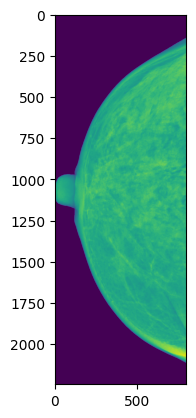

In [ ]:
path = df['Path_save'][0]
img = Image.open(path)
plt.imshow(img)
plt.show()

In [ ]:
img.mode

'L'

In [ ]:
df = df[['Path_save', 'Cancer']]
df.columns = ['images', 'label']
df.head()

,images,label
0,images/22678622_61b13c59bcba149e_MG_R_CC_ANON.png,0
1,images/22678646_61b13c59bcba149e_MG_L_CC_ANON.png,1
2,images/22678670_61b13c59bcba149e_MG_R_ML_ANON.png,0
3,images/22678694_61b13c59bcba149e_MG_L_ML_ANON.png,1
4,images/22614074_6bd24a0a42c19ce1_MG_R_CC_ANON.png,1


In [ ]:
for i in range(len(df)):
    if not os.path.exists(df['images'][i]):
        print('not found')
        break


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410 entries, 0 to 409
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  410 non-null    object
 1   label   410 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 6.5+ KB


In [ ]:
df['label'].value_counts(normalize=True)

1    0.836585
0    0.163415
Name: label, dtype: float64

In [ ]:
df['label'] = df['label'].astype(str)

# Baseline

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df, test_size=0.1, random_state=123)

X_train.shape, X_test.shape

((369, 20), (41, 20))

In [ ]:
train_data_generator = ImageDataGenerator(rescale = 1./255,
    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_data_generator = ImageDataGenerator(rescale = 1./255)

train = train_data_generator.flow_from_dataframe(dataframe=X_train,
                                                 x_col='images',
                                                 y_col='label',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 class_mode='binary',
                                                 shuffle=False)
test = test_data_generator.flow_from_dataframe(dataframe=X_test,
                                                x_col='images',
                                                y_col='label',
                                                target_size=(224,224),
                                                color_mode='rgb',
                                                class_mode='binary',
                                                shuffle=False)

Found 369 validated image filenames belonging to 2 classes.
Found 41 validated image filenames belonging to 2 classes.


In [ ]:
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model = tf.keras.Sequential([
    base_model,
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])


94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
model.compile(optimizer=tf.keras.optimizers.AdamW(),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.F1Score()]
              )

bobot sample

In [ ]:
# from sklearn.utils import compute_sample_weight
from sklearn.utils import class_weight

class_weights = class_weight.compute_sample_weight('balanced',
                                                   train.classes)

class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 0.599025974025974,
 1: 0.599025974025974,
 2: 0.599025974025974,
 3: 0.599025974025974,
 4: 0.599025974025974,
 5: 0.599025974025974,
 6: 0.599025974025974,
 7: 0.599025974025974,
 8: 0.599025974025974,
 9: 0.599025974025974,
 10: 0.599025974025974,
 11: 3.0245901639344264,
 12: 3.0245901639344264,
 13: 0.599025974025974,
 14: 0.599025974025974,
 15: 3.0245901639344264,
 16: 0.599025974025974,
 17: 0.599025974025974,
 18: 0.599025974025974,
 19: 0.599025974025974,
 20: 0.599025974025974,
 21: 0.599025974025974,
 22: 0.599025974025974,
 23: 3.0245901639344264,
 24: 0.599025974025974,
 25: 0.599025974025974,
 26: 0.599025974025974,
 27: 3.0245901639344264,
 28: 0.599025974025974,
 29: 3.0245901639344264,
 30: 0.599025974025974,
 31: 0.599025974025974,
 32: 0.599025974025974,
 33: 3.0245901639344264,
 34: 3.0245901639344264,
 35: 0.599025974025974,
 36: 0.599025974025974,
 37: 0.599025974025974,
 38: 0.599025974025974,
 39: 0.599025974025974,
 40: 0.599025974025974,
 41: 0.59902597402

bobot class

In [ ]:
from collections import Counter
counter = Counter(train.classes)
max_val = float(max(counter.values()))
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
class_weights

{1: 1.0, 0: 5.049180327868853}

In [ ]:
"""DRAFT ARCHITECTURE
"""

# class myCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         if logs.get('val_precision_2') > 0.92 and logs.get('val_recall_2') > 0.92:
#             print('\nTarget reached, stop training')
#             self.model.stop_training = True

# callbacks = myCallback()
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', save_best_only=True)


# history = model.fit(
#     train,
#     epochs=5,
#     validation_data=test,
    # callbacks= [reduce_lr, callbacks, early_stopping, checkpoint],
#     shuffle=True
# )



# model = tf.keras.Sequential([
#     base_model,
#     Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
#     MaxPooling2D(2, 2),
#     Dropout(0.5),
#     GlobalAveragePooling2D(),
#     Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
#     Dropout(0.5),
#     Dense(1, activation='sigmoid')
# ])

'DRAFT ARCHITECTURE\n'

train dengan sample weight

In [ ]:
history = model.fit(
    train,
    epochs=5,
    validation_data=test,
    shuffle=True,
    class_weight=class_weights_dict
)

Epoch 1/5
12/12 [==============================] - 43s 2s/step - loss: 0.4134 - precision: 0.8357 - recall: 0.9578 - f1_score: 0.9099 - val_loss: 0.5006 - val_precision: 0.8537 - val_recall: 1.0000 - val_f1_score: 0.9211
Epoch 2/5
12/12 [==============================] - 21s 2s/step - loss: 0.2913 - precision: 0.8343 - recall: 0.9805 - f1_score: 0.9099 - val_loss: 0.4615 - val_precision: 0.8537 - val_recall: 1.0000 - val_f1_score: 0.9211
Epoch 3/5
12/12 [==============================] - 21s 2s/step - loss: 0.2801 - precision: 0.8393 - recall: 0.9838 - f1_score: 0.9099 - val_loss: 0.4600 - val_precision: 0.8537 - val_recall: 1.0000 - val_f1_score: 0.9211
Epoch 4/5
12/12 [==============================] - 20s 2s/step - loss: 0.2587 - precision: 0.8385 - recall: 0.9610 - f1_score: 0.9099 - val_loss: 0.4692 - val_precision: 0.8421 - val_recall: 0.9143 - val_f1_score: 0.9211
Epoch 5/5
12/12 [==============================] - 27s 2s/step - loss: 0.2563 - precision: 0.8459 - recall: 0.9805 -

In [ ]:
cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

cnn.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='binary_crossentropy',
                metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.F1Score()]
                )

history_cnn = cnn.fit(
    train,
    epochs=5,
    validation_data=test,
    shuffle=True,
    class_weight=class_weights_dict
)

Epoch 1/5
12/12 [==============================] - 26s 2s/step - loss: 0.3535 - precision_1: 0.8343 - recall_1: 0.9481 - f1_score: 0.9099 - val_loss: 0.4281 - val_precision_1: 0.8537 - val_recall_1: 1.0000 - val_f1_score: 0.9211
Epoch 2/5
12/12 [==============================] - 22s 2s/step - loss: 0.2908 - precision_1: 0.8347 - recall_1: 1.0000 - f1_score: 0.9099 - val_loss: 0.4284 - val_precision_1: 0.8537 - val_recall_1: 1.0000 - val_f1_score: 0.9211
Epoch 3/5
12/12 [==============================] - 21s 2s/step - loss: 0.2800 - precision_1: 0.8347 - recall_1: 1.0000 - f1_score: 0.9099 - val_loss: 0.4260 - val_precision_1: 0.8537 - val_recall_1: 1.0000 - val_f1_score: 0.9211
Epoch 4/5
12/12 [==============================] - 21s 2s/step - loss: 0.2794 - precision_1: 0.8347 - recall_1: 1.0000 - f1_score: 0.9099 - val_loss: 0.4244 - val_precision_1: 0.8537 - val_recall_1: 1.0000 - val_f1_score: 0.9211
Epoch 5/5
12/12 [==============================] - 20s 2s/step - loss: 0.2670 - prec

In [ ]:
image_data_generator = ImageDataGenerator(rescale = 1./255)
sanity_test = image_data_generator.flow_from_dataframe(dataframe=df,
                                                x_col='images',
                                                y_col='label',
                                                target_size=(224,224),
                                                color_mode='rgb',
                                                class_mode='binary',
                                                shuffle=False)


from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

Found 732 validated image filenames belonging to 2 classes.


In [ ]:
y_pred_1 = model.predict(sanity_test)
y_pred_2 = cnn.predict(sanity_test)

<Axes: >

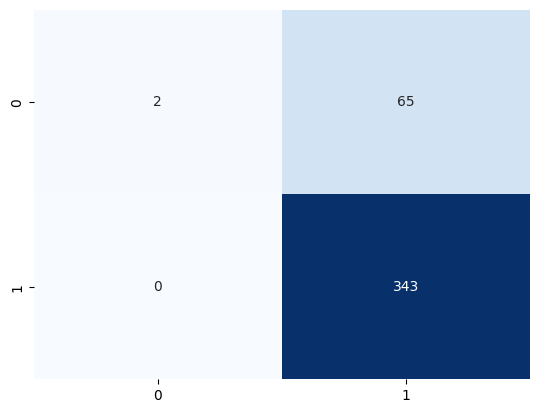

In [ ]:
y_pred_1 = np.round(y_pred_1)
y_pred_2 = np.round(y_pred_2)
y_true = sanity_test.labels
cm = confusion_matrix(y_true, y_pred_1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

<Axes: >

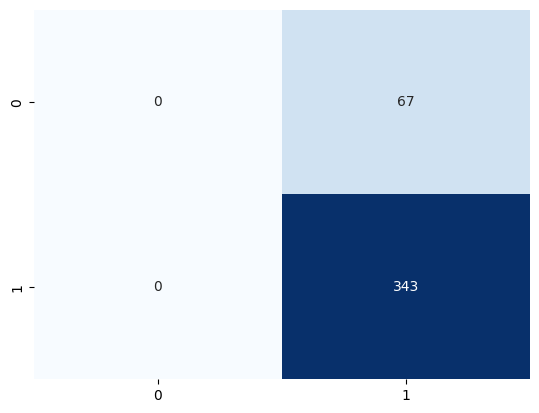

In [ ]:
cm2 = confusion_matrix(y_true, y_pred_2)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', cbar=False)

In [ ]:
len(sanity_test)

13

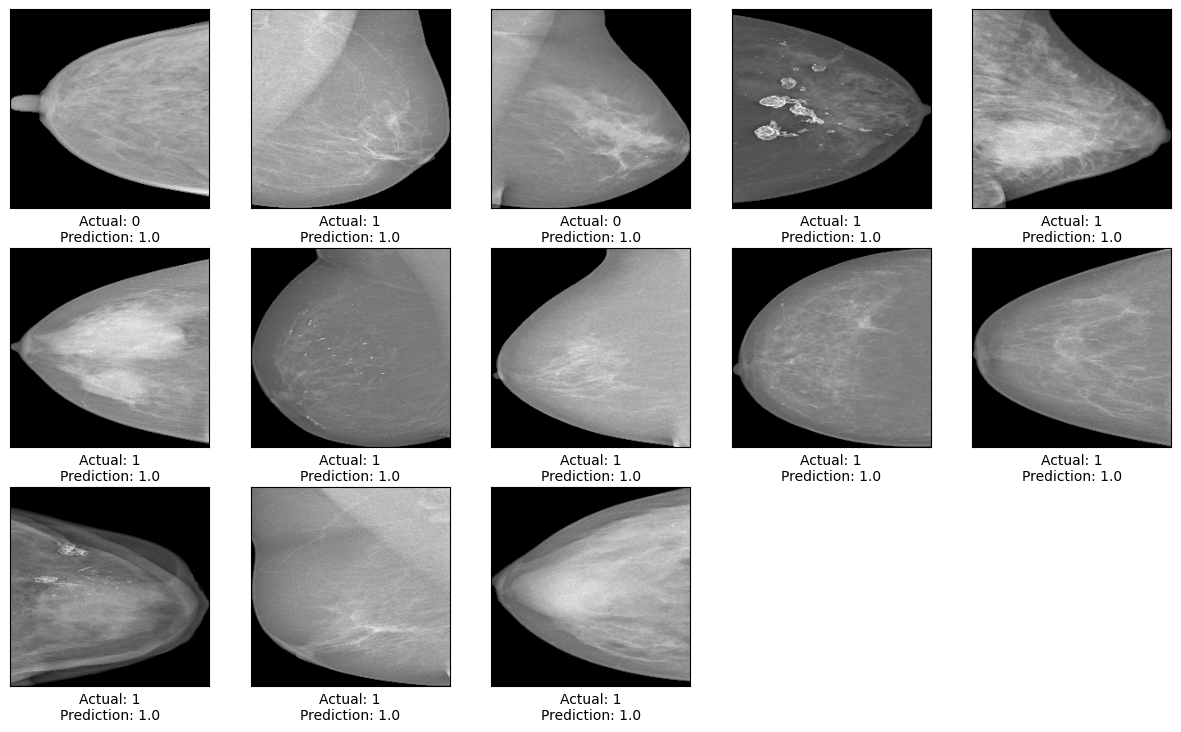

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(len(sanity_test)):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sanity_test[i][0][0])
    plt.xlabel(f'Actual: {y_true[i]}\nPrediction: {y_pred_1[i][0]}')
plt.show()

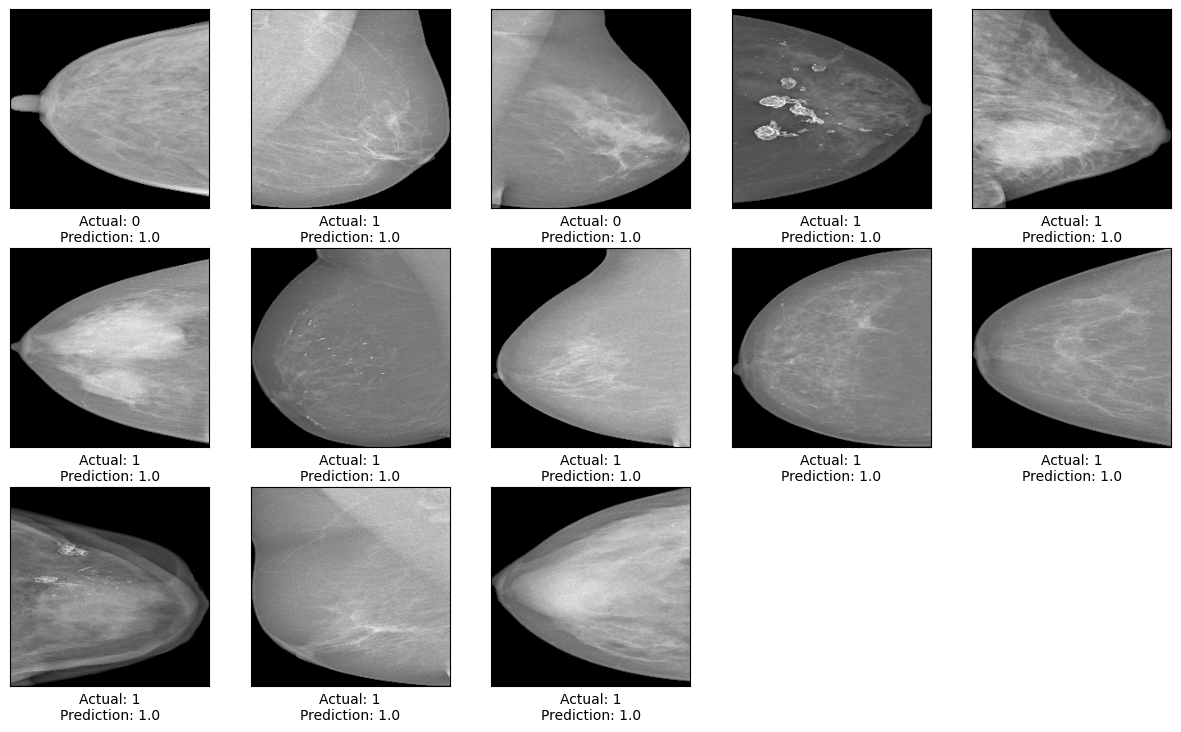

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(len(sanity_test)):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sanity_test[i][0][0])
    plt.xlabel(f'Actual: {y_true[i]}\nPrediction: {y_pred_2[i][0]}')
plt.show()

# Test dengan dataset lain

In [ ]:
!kaggle datasets download -d quachnam/mias-roi-mammography

 82% 49.0M/59.5M [00:00<00:00, 46.4MB/s]
100% 59.5M/59.5M [00:01<00:00, 60.4MB/s]


In [ ]:
!unzip mias-roi-mammography.zip

Archive:  mias-roi-mammography.zip
replace description.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: r
new name: test.csv
  inflating: test.csv                
  inflating: images/mdb001.png       
  inflating: images/mdb002.png       
  inflating: images/mdb003.png       
  inflating: images/mdb004.png       
  inflating: images/mdb005.png       
  inflating: images/mdb006.png       
  inflating: images/mdb007.png       
  inflating: images/mdb008.png       
  inflating: images/mdb009.png       
  inflating: images/mdb010.png       
  inflating: images/mdb011.png       
  inflating: images/mdb012.png       
  inflating: images/mdb013.png       
  inflating: images/mdb014.png       
  inflating: images/mdb015.png       
  inflating: images/mdb016.png       
  inflating: images/mdb017.png       
  inflating: images/mdb018.png       
  inflating: images/mdb019.png       
  inflating: images/mdb020.png       
  inflating: images/mdb021.png       
  inflating: images/mdb022.png       
  infla

In [ ]:
test_df = pd.read_csv('test.csv')
test_df.head()

,Refnum,Bg,Class,Severity,X,Y,Radius,Path,Cancer,Path_save
0,mdb001,G,CIRC,B,535.0,425.0,197.0,mdb001.png,0,images/mdb001.png
1,mdb002,G,CIRC,B,522.0,280.0,69.0,mdb002.png,0,images/mdb002.png
2,mdb003,D,NORM,NaN,NaN,NaN,NaN,mdb003.png,0,images/mdb003.png
3,mdb004,D,NORM,NaN,NaN,NaN,NaN,mdb004.png,0,images/mdb004.png
4,mdb005,F,CIRC,B,477.0,133.0,30.0,mdb005.png,0,images/mdb005.png


In [ ]:
test_df = test_df[['Path_save', 'Cancer']]
test_df = test_df.rename(columns={'Path_save': 'test_images', 'Cancer': 'test_label'})
test_df['test_label'] = test_df['test_label'].astype(str)

model resnet

In [ ]:
test2 = test_data_generator.flow_from_dataframe(dataframe=test_df,
                                                x_col='test_images',
                                                y_col='test_label',
                                                target_size=(224,224),
                                                color_mode='rgb',
                                                class_mode='binary',
                                                shuffle=False)

y_pred = model.predict(test2)

Found 322 validated image filenames belonging to 2 classes.
11/11 [==============================] - 4s 334ms/step


<Axes: >

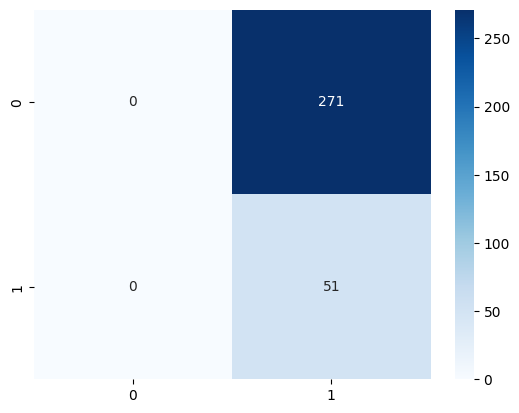

In [ ]:
y_pred = np.round(y_pred)
y_true = test2.labels
cm3 = confusion_matrix(y_true, y_pred)
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues')

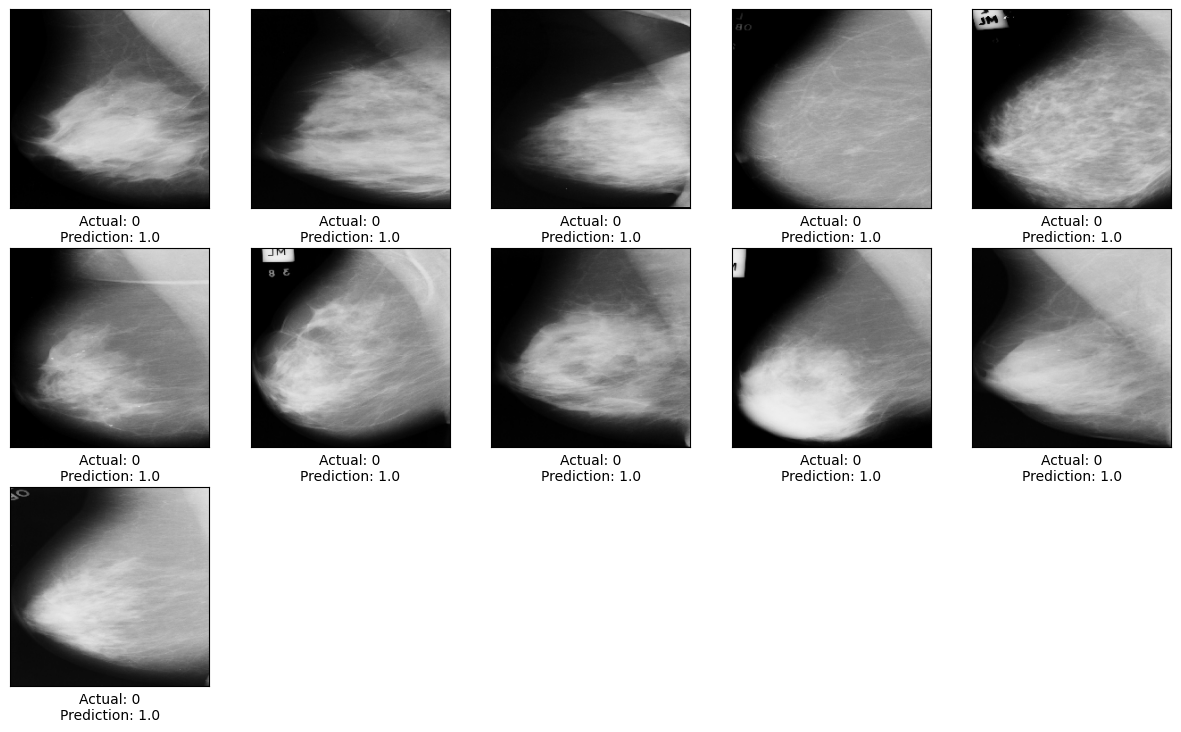

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(len(test2)):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test2[i][0][0])
    plt.xlabel(f'Actual: {y_true[i]}\nPrediction: {y_pred[i][0]}')
plt.show()

<h2>train dengan class weight

In [ ]:
history_2 = model.fit(
    train,
    epochs=5,
    validation_data=test,
    shuffle=True,
    class_weight=class_weights
)

Epoch 1/5
12/12 [==============================] - 24s 2s/step - loss: 1.1881 - precision: 0.9013 - recall: 0.6526 - f1_score: 0.9099 - val_loss: 1.1956 - val_precision: 0.8571 - val_recall: 0.1714 - val_f1_score: 0.9211
Epoch 2/5
12/12 [==============================] - 21s 2s/step - loss: 1.3002 - precision: 0.8995 - recall: 0.5519 - f1_score: 0.9099 - val_loss: 0.9350 - val_precision: 1.0000 - val_recall: 0.2286 - val_f1_score: 0.9211
Epoch 3/5
12/12 [==============================] - 21s 2s/step - loss: 1.2952 - precision: 0.9026 - recall: 0.5714 - f1_score: 0.9099 - val_loss: 1.2062 - val_precision: 0.8421 - val_recall: 0.4571 - val_f1_score: 0.9211
Epoch 4/5
12/12 [==============================] - 21s 2s/step - loss: 1.1733 - precision: 0.8934 - recall: 0.5714 - f1_score: 0.9099 - val_loss: 0.5520 - val_precision: 0.8750 - val_recall: 1.0000 - val_f1_score: 0.9211
Epoch 5/5
12/12 [==============================] - 21s 2s/step - loss: 1.4176 - precision: 0.8663 - recall: 0.4838 -

sanity test seluruh dataset awal

13/13 [==============================] - 16s 1s/step


<Axes: >

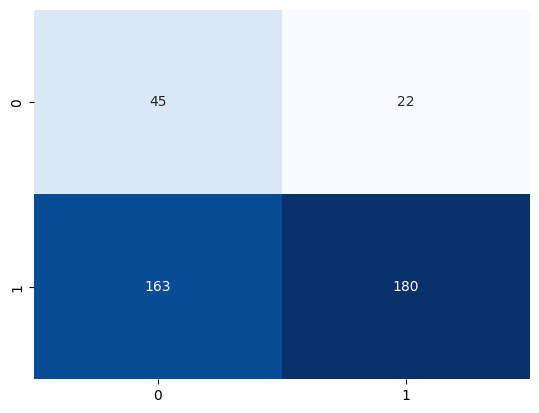

In [ ]:
y_pred_3 = model.predict(sanity_test)
y_pred_3 = np.round(y_pred_3)
y_true = sanity_test.labels

cm3 = confusion_matrix(y_true, y_pred_3)
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues', cbar=False)

test dengan dataset baru

11/11 [==============================] - 2s 204ms/step


<Axes: >

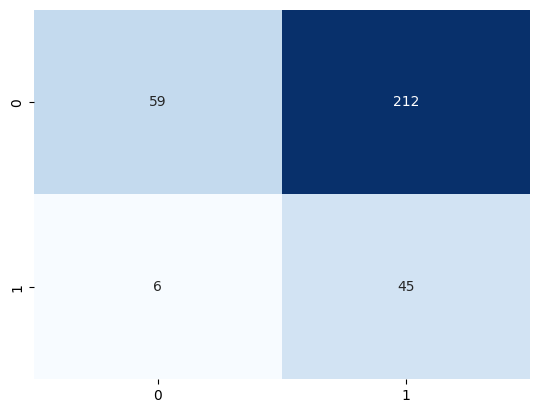

In [ ]:
y_pred_4 = model.predict(test2)
y_pred_4 = np.round(y_pred_4)
y_true = test2.labels

cm4 = confusion_matrix(y_true, y_pred_4)
sns.heatmap(cm4, annot=True, fmt='d', cmap='Blues', cbar=False)

# Stratified n No rotate

In [ ]:
X_train, X_test = train_test_split(df, test_size=0.1, random_state=123, stratify=df['label'])
X_train.shape, X_test.shape

((369, 2), (41, 2))

In [ ]:
train_data_generator = ImageDataGenerator(rescale = 1./255,
    width_shift_range=0.2,  # horizontal shift
    height_shift_range=0.2,  # vertical shift
    horizontal_flip=True,  # horizontal flip
    vertical_flip=True,  # vertical flip
    fill_mode='nearest')

test_data_generator = ImageDataGenerator(rescale = 1./255)

train3 = train_data_generator.flow_from_dataframe(dataframe=X_train,
                                                    x_col='images',
                                                    y_col='label',
                                                    target_size=(224,224),
                                                    color_mode='rgb',
                                                    class_mode='binary',
                                                    shuffle=False)

test3 = test_data_generator.flow_from_dataframe(dataframe=X_test,
                                                x_col='images',
                                                y_col='label',
                                                target_size=(224,224),
                                                color_mode='rgb',
                                                class_mode='binary',
                                                shuffle=False)

Found 369 validated image filenames belonging to 2 classes.
Found 41 validated image filenames belonging to 2 classes.


In [ ]:
model.compile(optimizer=tf.keras.optimizers.AdamW(),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.F1Score()]
              )

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_recall_3', factor=0.2, patience=3, min_lr=0.001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_recall_3', patience=5)
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', save_best_only=True)

history_3 = model.fit(
    train3,
    epochs=50,
    validation_data=test3,
    shuffle=True,
    class_weight=class_weights,
    callbacks=[reduce_lr, early_stopping, checkpoint]
)

model = tf.keras.models.load_model('model.h5')

Epoch 1/50
12/12 [==============================] - 27s 2s/step - loss: 1.1371 - accuracy: 0.6341 - precision_3: 0.9143 - recall_3: 0.6214 - f1_score: 0.9115 - val_loss: 0.7124 - val_accuracy: 0.5854 - val_precision_3: 0.9474 - val_recall_3: 0.5294 - val_f1_score: 0.9067 - lr: 0.0010
Epoch 2/50
12/12 [==============================] - 20s 2s/step - loss: 1.1635 - accuracy: 0.6125 - precision_3: 0.9109 - recall_3: 0.5955 - f1_score: 0.9115 - val_loss: 1.0301 - val_accuracy: 0.3171 - val_precision_3: 1.0000 - val_recall_3: 0.1765 - val_f1_score: 0.9067 - lr: 0.0010
Epoch 3/50
12/12 [==============================] - 21s 2s/step - loss: 1.1657 - accuracy: 0.5745 - precision_3: 0.8958 - recall_3: 0.5566 - f1_score: 0.9115 - val_loss: 0.6179 - val_accuracy: 0.6829 - val_precision_3: 0.8387 - val_recall_3: 0.7647 - val_f1_score: 0.9067 - lr: 0.0010
Epoch 4/50
12/12 [==============================] - 21s 2s/step - loss: 1.0820 - accuracy: 0.6206 - precision_3: 0.9043 - recall_3: 0.6117 - f1_s

13/13 [==============================] - 17s 1s/step


<Axes: >

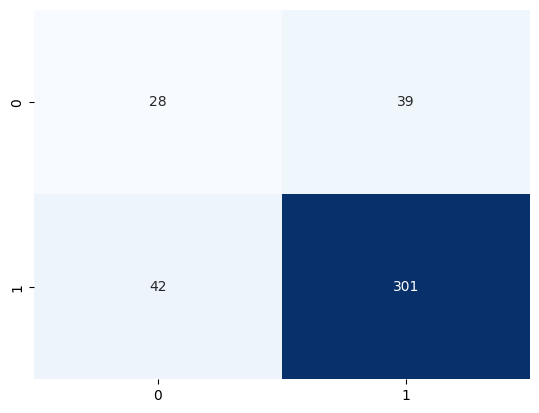

In [ ]:
y_pred_5 = model.predict(sanity_test)
y_pred_5 = np.round(y_pred_5)
y_true = sanity_test.labels

cm5 = confusion_matrix(y_true, y_pred_5)
sns.heatmap(cm5, annot=True, fmt='d', cmap='Blues', cbar=False)

11/11 [==============================] - 2s 210ms/step


<Axes: >

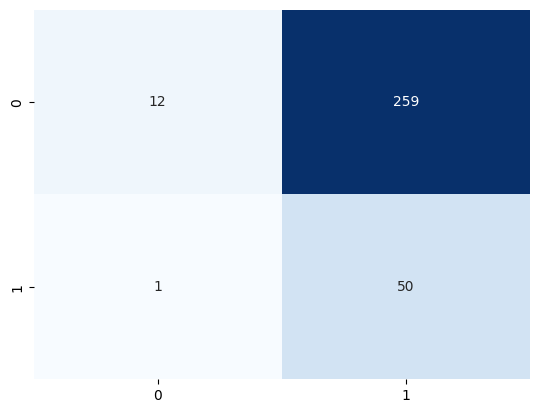

In [ ]:
y_pred_6 = model.predict(test2)
y_pred_6 = np.round(y_pred_6)
y_true = test2.labels

cm6 = confusion_matrix(y_true, y_pred_6)
sns.heatmap(cm6, annot=True, fmt='d', cmap='Blues', cbar=False)

# kfold

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=123)

X = df

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]

    train_data_generator = ImageDataGenerator(rescale = 1./255,
        width_shift_range=0.2,  # horizontal shift
        height_shift_range=0.2,  # vertical shift
        horizontal_flip=True,  # horizontal flip
        vertical_flip=True,  # vertical flip
        fill_mode='nearest')

    test_data_generator = ImageDataGenerator(rescale = 1./255)

    train4 = train_data_generator.flow_from_dataframe(dataframe=X_train,
                                                        x_col='images',
                                                        y_col='label',
                                                        target_size=(224,224),
                                                        color_mode='rgb',
                                                        class_mode='binary',
                                                        shuffle=False)

    test4 = test_data_generator.flow_from_dataframe(dataframe=X_test,
                                                    x_col='images',
                                                    y_col='label',
                                                    target_size=(224,224),
                                                    color_mode='rgb',
                                                    class_mode='binary',
                                                    shuffle=False)

    model.compile(optimizer=tf.keras.optimizers.AdamW(),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.F1Score()]
              )

    reduce_lr = ReduceLROnPlateau(monitor='val_recall_5', factor=0.2, patience=3, min_lr=0.001)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_recall_5', patience=5)
    checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', save_best_only=True)

    history_4 = model.fit(
        train4,
        epochs=50,
        validation_data=test4,
        shuffle=True,
        class_weight=class_weights,
        callbacks=[reduce_lr, early_stopping, checkpoint]
    )

    model = tf.keras.models.load_model('model.h5')

    break

Found 328 validated image filenames belonging to 2 classes.
Found 82 validated image filenames belonging to 2 classes.
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 1.0846 - accuracy: 0.6951 - precision_5: 0.9108 - recall_5: 0.7055 - f1_score: 0.9121

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 62s 2s/step - loss: 1.0846 - accuracy: 0.6951 - precision_5: 0.9108 - recall_5: 0.7055 - f1_score: 0.9121 - val_loss: 0.7416 - val_accuracy: 0.5244 - val_precision_5: 0.8537 - val_recall_5: 0.5147 - val_f1_score: 0.9067 - lr: 0.0010
Epoch 2/50
11/11 [==============================] - 20s 2s/step - loss: 1.0831 - accuracy: 0.7134 - precision_5: 0.9209 - recall_5: 0.7200 - f1_score: 0.9121 - val_loss: 0.9622 - val_accuracy: 0.4268 - val_precision_5: 0.8621 - val_recall_5: 0.3676 - val_f1_score: 0.9067 - lr: 0.0010
Epoch 3/50
11/11 [==============================] - 21s 2s/step - loss: 1.0269 - accuracy: 0.5549 - precision_5: 0.9329 - recall_5: 0.5055 - f1_score: 0.9121 - val_loss: 0.6552 - val_accuracy: 0.5976 - val_precision_5: 0.8571 - val_recall_5: 0.6176 - val_f1_score: 0.9067 - lr: 0.0010
Epoch 4/50
11/11 [==============================] - 22s 2s/step - loss: 0.9886 - accuracy: 0.7683 - precision_5: 0.9061 - recall_5: 0.8073 - f1_score: 0.912

11/11 [==============================] - 3s 271ms/step


<Axes: >

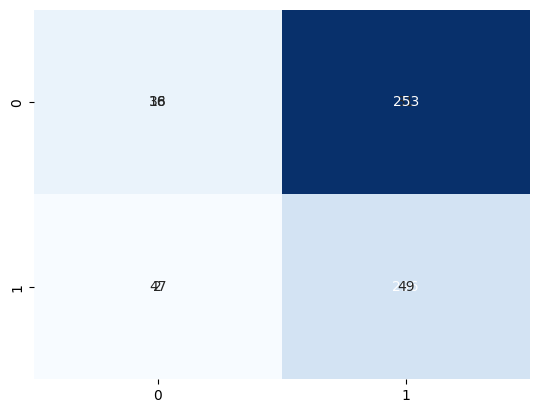

In [ ]:
    y_pred_7 = model.predict(sanity_test)
    y_pred_7 = np.round(y_pred_7)
    y_true = sanity_test.labels

    cm7 = confusion_matrix(y_true, y_pred_7)
    sns.heatmap(cm7, annot=True, fmt='d', cmap='Blues', cbar=False)

    y_pred_8 = model.predict(test2)
    y_pred_8 = np.round(y_pred_8)
    y_true = test2.labels

    cm8 = confusion_matrix(y_true, y_pred_8)
    sns.heatmap(cm8, annot=True, fmt='d', cmap='Blues', cbar=False)

# penambahan data

In [ ]:
df = pd.read_csv('description.csv')
test_df = pd.read_csv('test.csv')
df = df[['Path_save', 'Cancer']]
df = df.rename(columns={'Path_save': 'images', 'Cancer': 'label'})
test_df = test_df[['Path_save', 'Cancer']]
test_df = test_df.rename(columns={'Path_save': 'images', 'Cancer': 'label'})

df = pd.concat([df, test_df], axis=0)
df['label'] = df['label'].astype(str)

In [ ]:
df['label'].value_counts()

1    394
0    338
Name: label, dtype: int64

In [ ]:
df = df.sample(frac=1, random_state=123).reset_index(drop=True)
df

,images,label
0,images/mdb112.png,0
1,images/mdb012.png,0
2,images/20587544_d571b5880ad2a016_MG_R_CC_ANON.png,1
3,images/22670124_e1f51192f7bf3f5f_MG_L_CC_ANON.png,1
4,images/22670278_98429c0bdf78c0c7_MG_R_CC_ANON.png,1
...,...,...
727,images/50993895_de5e8d61e501a71b_MG_L_ML_ANON.png,1
728,images/53582737_465aa5ec1b59efc6_MG_L_ML_ANON.png,1
729,images/53581124_3be876aecfaad4ca_MG_L_ML_ANON.png,0
730,images/22580680_fe7d005dcbbfb46d_MG_L_CC_ANON.png,1


In [ ]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=123, stratify=df['label'])
X_train.shape, X_test.shape

((585, 2), (147, 2))

In [ ]:
train_data_generator = ImageDataGenerator(rescale = 1./255,
    width_shift_range=0.2,  # horizontal shift
    height_shift_range=0.2,  # vertical shift
    horizontal_flip=True,  # horizontal flip
    vertical_flip=True,  # vertical flip
    fill_mode='nearest')

test_data_generator = ImageDataGenerator(rescale = 1./255)

train = train_data_generator.flow_from_dataframe(dataframe=X_train,
                                                    x_col='images',
                                                    y_col='label',
                                                    target_size=(224,224),
                                                    color_mode='rgb',
                                                    class_mode='binary',
                                                    shuffle=False)

test = test_data_generator.flow_from_dataframe(dataframe=X_test,
                                                x_col='images',
                                                y_col='label',
                                                target_size=(224,224),
                                                color_mode='rgb',
                                                class_mode='binary',
                                                shuffle=False)

Found 585 validated image filenames belonging to 2 classes.
Found 147 validated image filenames belonging to 2 classes.


In [ ]:
# model
model = tf.keras.Sequential([
    base_model,
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.F1Score()]
              )

In [ ]:
from collections import Counter
counter = Counter(train.classes)
max_val = float(max(counter.values()))
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
class_weights

{1: 1.0, 0: 1.1666666666666667}

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2, min_lr=0.001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', save_best_only=True)

history_5 = model.fit(
    train,
    epochs=50,
    validation_data=test,
    shuffle=True,
    class_weight=class_weights,
    callbacks=[reduce_lr, early_stopping, checkpoint],
    verbose=1
)

# load
model = tf.keras.models.load_model('model.h5')



Epoch 1/50
19/19 [==============================] - ETA: 0s - loss: 0.6165 - accuracy: 0.7419 - precision: 0.7628 - recall: 0.7556 - f1_score: 0.7000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/19 [==============================] - 38s 1s/step - loss: 0.6165 - accuracy: 0.7419 - precision: 0.7628 - recall: 0.7556 - f1_score: 0.7000 - val_loss: 0.5745 - val_accuracy: 0.7891 - val_precision: 0.8077 - val_recall: 0.7975 - val_f1_score: 0.6991 - lr: 1.0000e-04
Epoch 2/50
19/19 [==============================] - 28s 1s/step - loss: 0.5156 - accuracy: 0.8222 - precision: 0.8392 - recall: 0.8286 - f1_score: 0.7000 - val_loss: 0.6265 - val_accuracy: 0.7347 - val_precision: 0.8125 - val_recall: 0.6582 - val_f1_score: 0.6991 - lr: 1.0000e-04
Epoch 3/50
19/19 [==============================] - 31s 2s/step - loss: 0.5055 - accuracy: 0.8188 - precision: 0.8449 - recall: 0.8127 - f1_score: 0.7000 - val_loss: 0.4992 - val_accuracy: 0.8027 - val_precision: 0.8125 - val_recall: 0.8228 - val_f1_score: 0.6991 - lr: 1.0000e-04
Epoch 4/50
19/19 [==============================] - 27s 1s/step - loss: 0.4742 - accuracy: 0.8342 - precision: 0.8449 - recall: 0.8476 - f1_score: 0.7000 - val_loss: 0.

23/23 [==============================] - 21s 916ms/step


<Axes: >

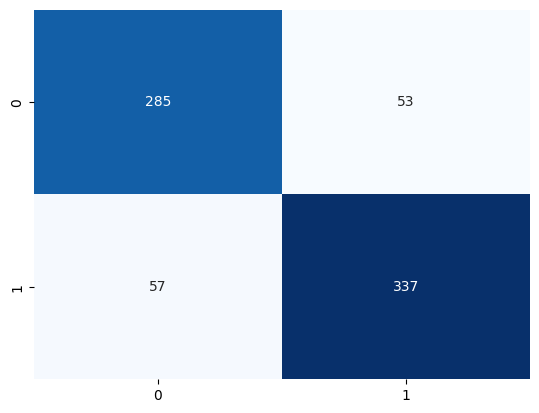

In [ ]:
y_pred_9 = model.predict(sanity_test)
y_pred_9 = np.round(y_pred_9)
y_true = sanity_test.labels

cm9 = confusion_matrix(y_true, y_pred_9)
sns.heatmap(cm9, annot=True, fmt='d', cmap='Blues', cbar=False)